In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import category_encoders as ce

'''
rmse=mean_squared_error(y_true,y_pred,squared=False)
'''



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



C:\Users\USER\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
try:
    train_df = pd.read_csv('./train.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'car_prices.csv' was not found. Please check the file path.")

Data loaded successfully!


In [251]:
train_df.head(5)

id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

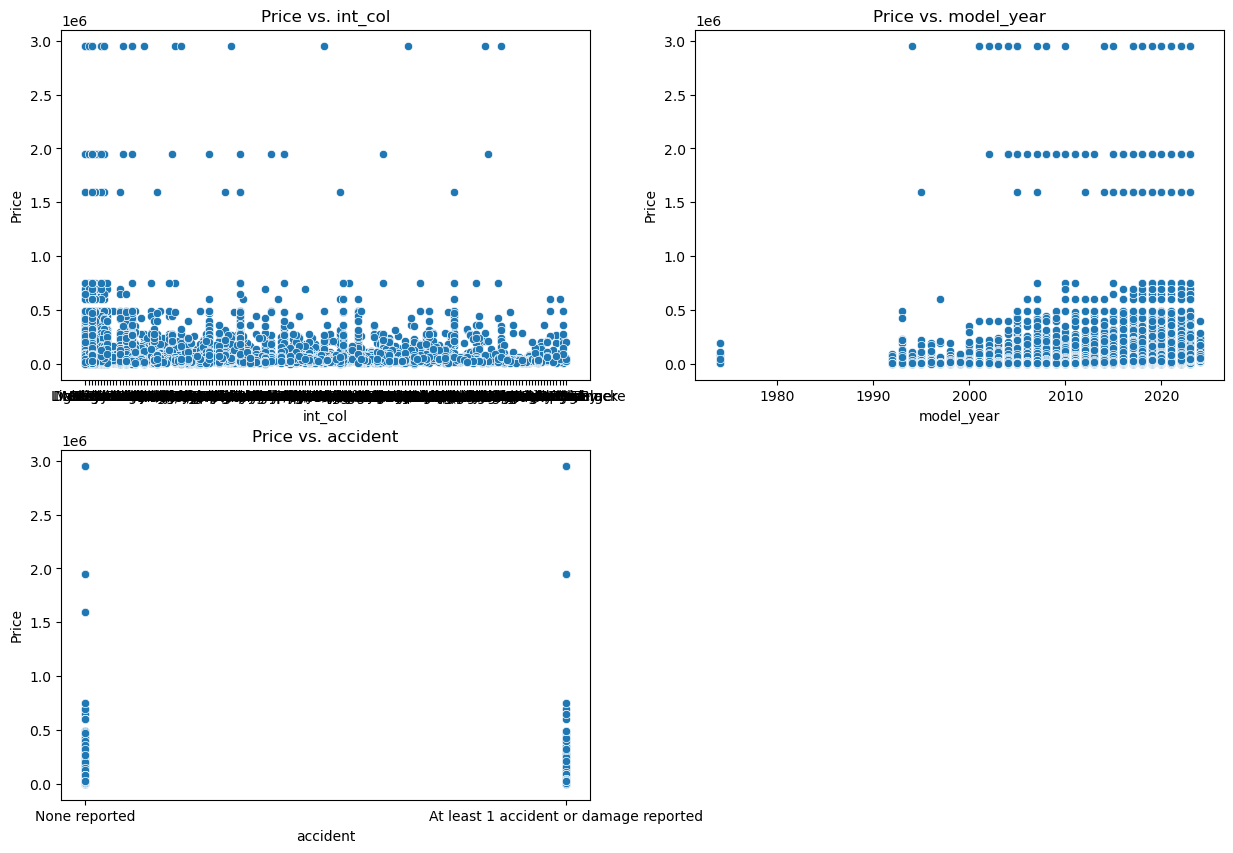

In [121]:
def plots(columns,ncols_for_subplot, df):
    ncols = ncols_for_subplot
    nrows = -(-len(columns) // ncols)  # ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.scatterplot(x=col, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Price vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Price')

    # hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()
plots(["int_col", 'model_year','accident'], 2, train_df)

In [122]:
categorical_cols = train_df.select_dtypes(include='object').columns
numerical_cols = train_df.select_dtypes(exclude='object').columns
def exploratory_data_analysis(df):
    '''This function performs some preliminary EDA. You are free to add more to it to 
       guide you in preparing your dataset for trainiing
    '''
    print("First 5 rows of the dataset:")
    print(df.head())
    
    # Get information about the dataset (data types, non-null values)
    print("\nDataset information:")
    df.info()
    
    # Get descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe())
    #Get descriptive statistics for categorical columns
    print("\nDescriptive statistics for categorical columns:")
    print(df.describe(include='object'))
    #Checking for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    # Visualize the distribution of the target variable (price)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True, bins=50)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()
    
    
    # Visualizing the relationship between all numerical features and price
    # For example, 'mileage' and 'price'
    print('Plotting numerical variables vs price')
    numerical_plot=plots(numerical_cols,2,df)
   

First 5 rows of the dataset:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2     

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


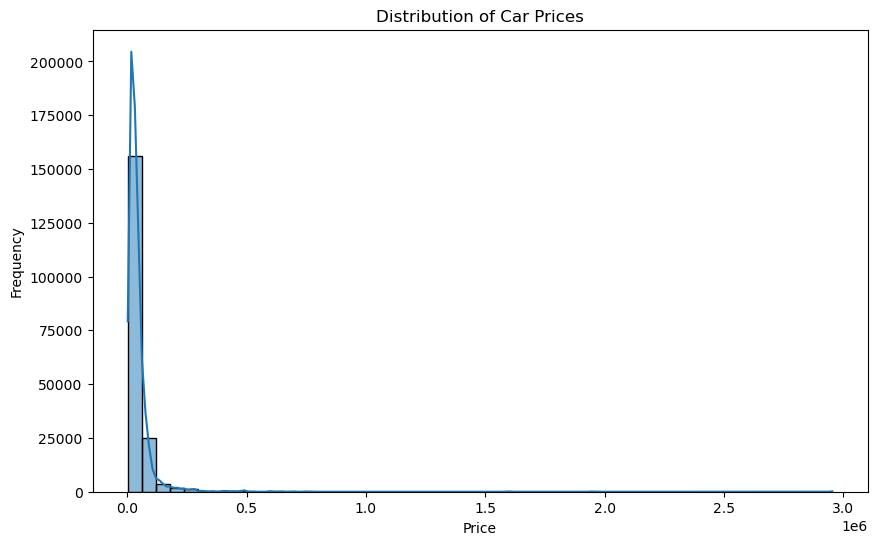

Plotting numerical variables vs price


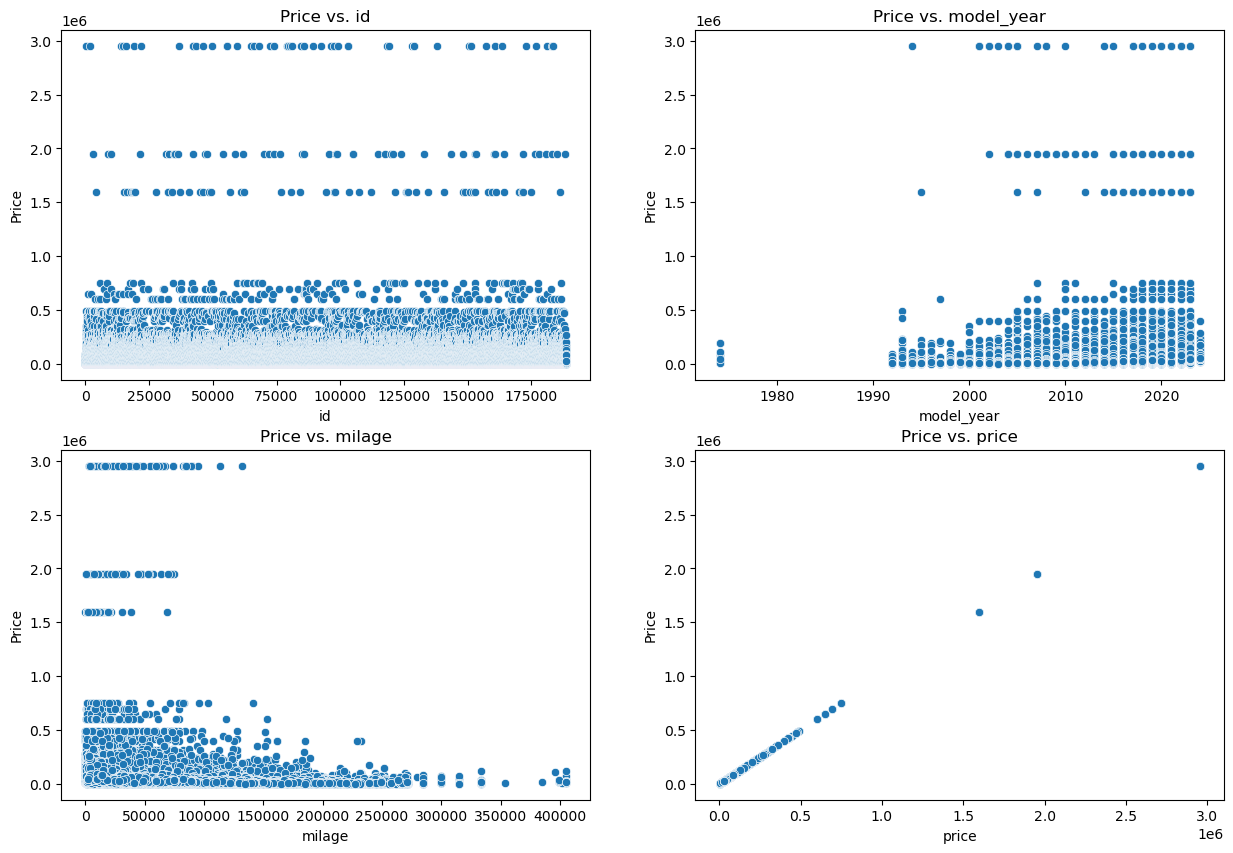

In [123]:
exploratory_data_analysis(train_df)

In [124]:
def filling_missing_values_in_numerical_columns(df):
    numerical_cols_with_missing = ['hp', 'litres','cylinders'] 

    # Fill missing values using the median of each column
    for col in numerical_cols_with_missing:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
    
    print("DataFrame after filling numerical missing values:")
    print(df.info())
    return df

In [125]:
 def filling_missing_values_in_categorical_columns(df):
        categorical_cols_with_missing = ['accident', 'fuel_type'] # Replace with your columns
        # You could fill missing values using the mode of each column. Feel free to choose your strategy
        for col in categorical_cols_with_missing:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
        
        print("DataFrame after filling categorical missing values:")
        print(df.info())
        return df


C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

Empty DataFrame
Columns: [id, brand, model, model_year, milage, fuel_type, engine, transmission, ext_col, int_col, accident, clean_title, price]
Index: []


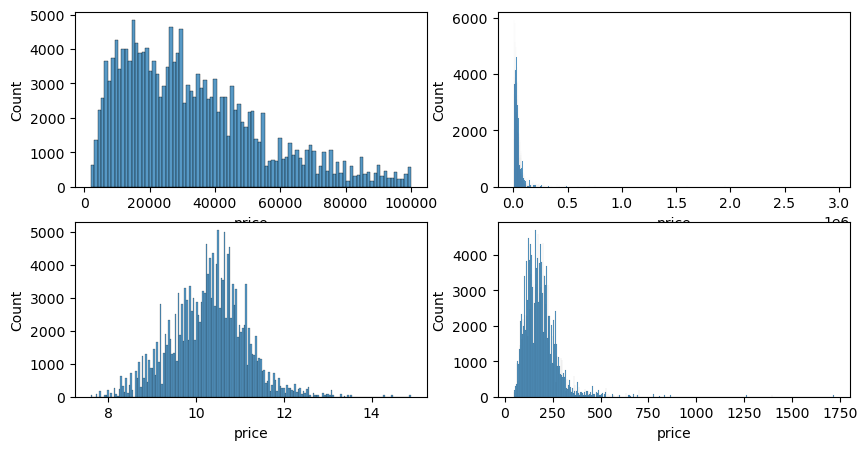

In [126]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
low_price= train_df[train_df.price<100000]
sns.histplot(low_price['price'])

plt.subplot(2, 2, 2)
sns.histplot(train_df['price'])
plt.subplot(2, 2, 3)
sns.histplot(np.log1p(train_df['price']))
plt.subplot(2,2,4)
sns.histplot(np.sqrt(train_df['price']))

# Log1p for the price for normalisation

print(train_df[train_df.price==0])

<Axes: xlabel='accident', ylabel='price'>

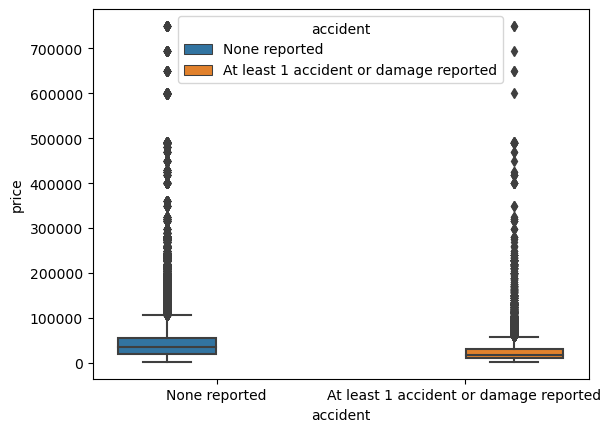

In [127]:
sns.boxplot(data=train_df[train_df.price<1000000], x="accident",y="price", hue='accident')

In [128]:
train_df[train_df.price>=2000000]


id          brand  \
220        220           Ford   
1880      1880       Chrysler   
13838    13838         Toyota   
14693    14693        Hyundai   
16034    16034  Mercedes-Benz   
18946    18946           Audi   
21814    21814            RAM   
36615    36615           Ford   
42177    42177           Ford   
42219    42219           Land   
43218    43218          Tesla   
46159    46159      Chevrolet   
49575    49575            RAM   
55428    55428          Lexus   
55493    55493          Lexus   
59650    59650         Toyota   
65043    65043  Mercedes-Benz   
66224    66224      Chevrolet   
67957    67957           Land   
72448    72448  Mercedes-Benz   
74189    74189  Mercedes-Benz   
79269    79269           Ford   
79469    79469          Aston   
80269    80269            GMC   
81056    81056           Ford   
84731    84731  Mercedes-Benz   
85611    85611      Chevrolet   
89180    89180           Ford   
92612    92612          Lexus   
96473    96473           Ford   
97654    97654        Pontiac   
99283    99283           Land   
103061  103061            RAM   
103189  103189          Dodge   
118167  118167      Chevrolet   
119162  119162           Ford   
128002  128002            RAM   
129013  129013  Mercedes-Benz   
129054  129054       INFINITI   
138122  138122       Cadillac   
150549  150549            RAM   
151415  151415           Ford   
157056  157056       Cadillac   
160629  160629          Honda   
163487  163487           Land   
172766  172766          Lexus   
176936  176936       Cadillac   
181021  181021       Cadillac   
183006  183006           Land   
183468  183468        Bentley   

                                                    model  model_year  milage  \
220                                             F-150 XLT        2021   26315   
1880                                            300C Base        2003   55900   
13838                                       Highlander SE        2014   85000   
14693                                        Santa Fe SEL        2022   13865   
16034                             SL-Class SL500 Roadster        2005   34068   
18946                                             S4 Base        2004   73500   
21814                                        1500 Laramie        2022   16156   
36615                          Excursion Limited Ultimate        2002   89900   
42177                                          Mustang GT        2005   82000   
42219          Rover Range Rover 3.0L V6 Supercharged HSE        2021   29850   
43218                                  Model 3 Long Range        2021   22457   
46159                                            Tahoe LT        2018   83858   
49575                                        1500 Laramie        2022   13610   
55428                                         LS 430 Base        2004   39750   
55493                                         LS 430 Base        2002   27600   
59650                                      Highlander XLE        2022   13566   
65043                   AMG GLE AMG GLE 63 S-Model 4MATIC        2017    4590   
66224                                       Corvette Base        2005   23133   
67957   Rover Range Rover 5.0L Supercharged Autobiogra...        2017   67280   
72448                             SL-Class SL550 Roadster        2001  113500   
74189                                         Metris Base        2020    9686   
79269                               Expedition Timberline        2021    7758   
79469                          Martin DB7 Vantage Volante        2005   89900   
80269                       Sierra 1500 SLE1 Extended Cab        2020    2750   
81056                                            F-150 XL        2022    4200   
84731                                      AMG GT 53 Base        2023    2823   
85611                    Silverado 1500 Custom Trail Boss        2022    5072   
89180                           Expedition Max King Ranch   

<Axes: >

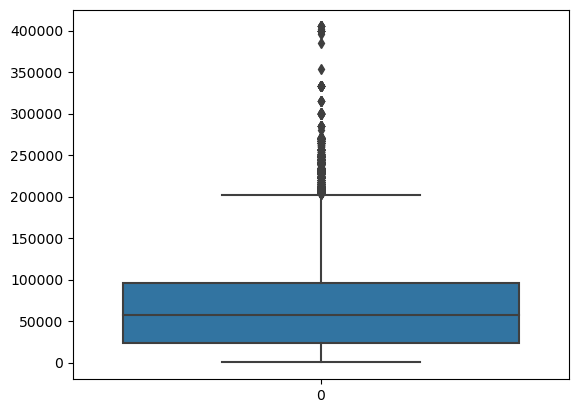

In [129]:
sns.boxplot(train_df.milage)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='milage', ylabel='Count'>

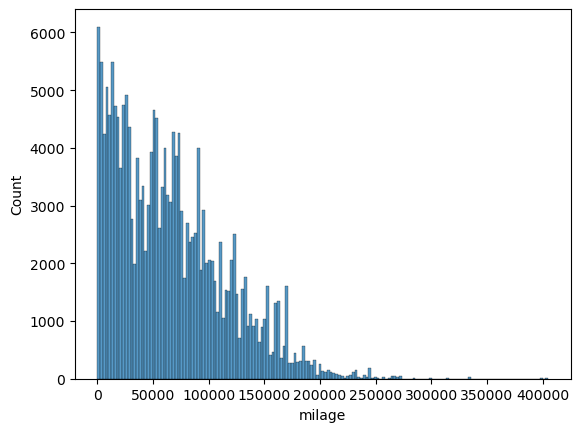

In [130]:
sns.histplot(train_df.milage)

In [131]:
 train_df.groupby("model").agg(
        count=("model", "size"),      
        mean_price=("price", "mean"),  
        min_price=("price", "min"),
        max_price=("price", "max"),
        **{col: ("model", "count") for col in []}  
 ).sort_values("count", ascending=True).head(10)

count  mean_price  min_price  max_price
model                                                                 
X5 xDrive40e                       1     90000.0      90000      90000
Integra w/A-Spec Tech Package      1     45999.0      45999      45999
X5 3.0i                            1     21000.0      21000      21000
XLR Base                           1     32500.0      32500      32500
IONIQ Plug-In Hybrid SEL           2     32400.0      29800      35000
X5 3.0si                           2     28975.0      15000      42950
V60 T6 R-Design Platinum           2     40950.0      21900      60000
Forte LX                           2     21289.5      14980      27599
XLR V                              2     56375.0      15900      96850
X3 xDrive35i                       2     44997.5      36995      53000

<Axes: xlabel='milage', ylabel='price'>

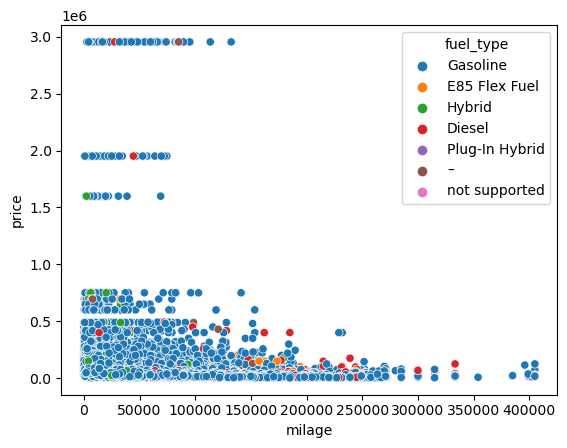

In [132]:
sns.scatterplot(data=train_df, x='milage',y='price',hue='fuel_type')

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\lib\site-packages\seaborn\relational.py:441: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()


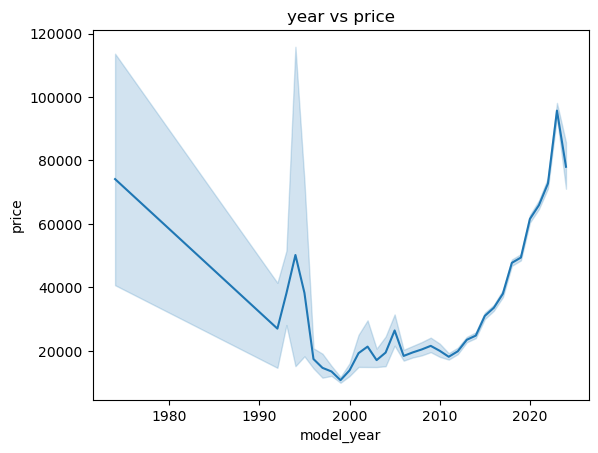

In [133]:
sns.lineplot(data = train_df, x = "model_year", y="price")
plt.title("year vs price")
plt.show()

Feature engineering

In [134]:
train_df['transmission'].unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


In [135]:
def transmission_sort(df):
    df["transmission"]=df["transmission"].str.lower().str.strip().str.replace(" ","-")
    df["transmission_speed"]= df["transmission"].apply(lambda x: x.split("speed")[0] if "speed" in x else "")
    df["transmission_mode"]= df["transmission"].apply(lambda x: x.split("speed")[1] if "speed" in x else x)
transmission_sort(train_df)

In [136]:
train_df["transmission_mode"].unique()

array(['a/t', 'transmission-w/dual-shift-mode', '-a/t', '-automatic',
       'automatic', '-automatic-with-auto-shift', 'cvt-transmission',
       '-m/t', 'm/t', 'automatic-cvt', '-manual',
       'transmission-overdrive-switch',
       '-electronically-controlled-automatic-with-o', 'f', 'cvt-f',
       'manual', '–', '2', '-at/mt', '', 'variable', '-fixed-gear', '-at',
       '-automatic-with-overdrive', '-dct-automatic',
       'scheduled-for-or-in-production', '-mt'], dtype=object)

In [137]:
class modeNormalizer:
    def __init__(self):
        self.mapping={
             "autoshift":["transmission-w/dual-shift-mode","-at/mt"],
            "overdrive_automatic":["-automatic-with-overdrive","transmission-overdrive-switch","electronically_automatic"],
            "automatic-cvt":["automatic-cvt"],
            "automatic-dct":["-dct-automatic"],
            "fixed-gear":["fixed-gear"],
            "automatic":["a/t","-a/t","-automatic","automatic","-at"],
            "manual":["-m/t","m/t","-manual", "-mt"],
            "cvt":["cvt-transmission","cvt-f","f","variable"],
           
        }
    def normalize(self, val:str):
        val = str(val)
        for key, variants in self.mapping.items():
            if any(v in val for v in variants):
                return key
        return "others"

In [138]:
normalizer = modeNormalizer()
train_df["transmission_mode"]= train_df["transmission_mode"].apply(normalizer.normalize)

In [139]:
train_df["transmission_mode"].unique()

array(['automatic', 'autoshift', 'cvt', 'manual', 'automatic-cvt',
       'overdrive_automatic', 'others', 'fixed-gear', 'automatic-dct'],
      dtype=object)

In [140]:
def speedNormalizer(df):
    df["transmission_speed"]=df["transmission_speed"].apply(lambda x: x.split("-")[0] if "-" in x else 5)
    df["transmission_speed"]=df["transmission_speed"].replace("single",1)
    df["transmission_speed"]=pd.to_numeric(df["transmission_speed"])
    df["transmission_speed"].value_counts()


In [141]:
speedNormalizer(train_df)
train_df["transmission_speed"].unique()

array([ 5,  7,  8, 10,  1,  6,  9,  4,  2], dtype=int64)

In [142]:
train_df["engine"].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [143]:
count_HP = train_df["engine"].str.contains("HP").sum()
print(count_HP)

155274


In [144]:
count_L = train_df["engine"].str.contains("L").sum()
print(count_L)

181835


In [145]:
count_L = train_df["engine"].str.contains("Cylinder").sum()
print(count_L)

150678


In [146]:
import re

def parse_engine_info(engine_str):
    engine_str = engine_str.upper()

    # Default values
    litres= None
    hp=None
    cylinders = None
    shape = None
    engine_type = None
    
      # Horsepower
    hp_match = re.search(r'([\d\.]+)\s*HP', engine_str)
    hp = float(hp_match.group(1)) if hp_match else np.nan

    # Litres (match both "L" and "Liter")
    litres_match = re.search(r'([\d\.]+)\s*(?:L|LITER)', engine_str)
    litres = float(litres_match.group(1)) if litres_match else np.nan

    # Detect cylinders & shape
    v_match = re.search(r'V(\d+)', engine_str)
    cyl_match = re.search(r'(\d+)\s*CYLINDER', engine_str)

    if v_match:
        cylinders = int(v_match.group(1))
        shape = "V"
    elif cyl_match:
        cylinders = int(cyl_match.group(1))
        shape = "Straight"

    if "DOHC" in engine_str or "GDI" in engine_str:
        engine_type = "DOHC"
    elif "ELECTRIC" in engine_str or "BATTERY" in engine_str:
        engine_type = "Electric"
    elif "TURBO" in engine_str:
        engine_type = "Turbo"
    elif "CYLINDER" in engine_str:
        engine_type = "Cylinder"
    elif "MPFI" in engine_str:
        engine_type = "MPFI"
    elif "ROTARY" in engine_str:
        engine_type = "Rotary"

    return hp, litres, cylinders, shape, engine_type


train_df[["hp", "litres","cylinders", "shape", "engine_type"]] = train_df["engine"].apply(lambda x: pd.Series(parse_engine_info(x)))


In [147]:
train_df.head()

id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             a/t  Yellow    Gray   
1                             a/t  Silver   Beige   
2                             a/t    Blue    Gray   
3  transmission-w/dual-shift-mode   Black   Black   
4                     7-speed-a/t   Black   Beige   

                                 accident clean_title  price  \
0                           None reported         Yes   4200   
1  At least 1 accident or damage reported         Yes   4999   
2                           None reported         Yes  13900   
3                           None reported         Yes  45000   
4                           None reported         Yes  97500   

   transmission_speed transmission_mode     hp  litres  cylinders     shape  \
0                   5         automatic  172.0     1.6        4.0  Straight   
1                   5         automatic  252.0     3.9        8.0  Straight   
2                   5         automatic  320.0     5.3        8.0  Straight   
3                   5         autoshift  420.0     5.0        8.0  Straight   
4                   7         automatic  208.0     2.0        4.0  Straight   

  engine_type  
0    Cylinder  
1    Cylinder  
2    Cylinder  
3    Cylinder  
4    Cylinder

In [148]:
d= train_df[train_df["engine"].str.contains("Electric")]
print(d.shape)
print(d["fuel_type"].value_counts())
d.isnull().sum()

(11139, 20)
fuel_type
Hybrid            4911
Gasoline           860
Plug-In Hybrid     496
not supported        6
E85 Flex Fuel        2
Diesel               1
–                    1
Name: count, dtype: int64


id                       0
brand                    0
model                    0
model_year               0
milage                   0
fuel_type             4862
engine                   0
transmission             0
ext_col                  0
int_col                  0
accident               156
clean_title            608
price                    0
transmission_speed       0
transmission_mode        0
hp                     775
litres                5402
cylinders             5471
shape                 5471
engine_type              0
dtype: int64

In [149]:
train_df.loc[train_df["fuel_type"].isna()&train_df["engine"].str.contains("Electric"),"fuel_type"]="Electric"

In [150]:
train_df["fuel_type"].isna().sum()

221

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\lib\site-packages\seaborn\relational.py:441: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()


<Axes: xlabel='hp', ylabel='price'>

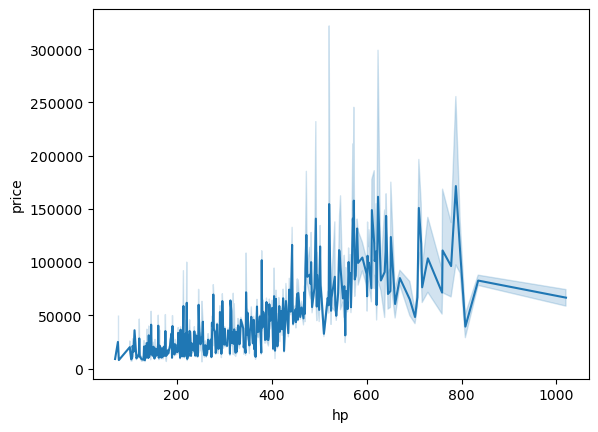

In [151]:
sns.lineplot(data=train_df, x="hp", y="price")

In [152]:
train_df["accident"].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [153]:
def encodeAccident(df):
    accidentmapping = {
    "At least 1 accident or damage reported":0,
    "None reported": 1,
    }
    df['accident'] = df["accident"].map(accidentmapping)


In [154]:
encodeAccident(train_df)

In [155]:
def convert_year_to_age(df):
    current_year = 2025
    df["car_age"]= current_year-df["model_year"]
    df.drop("model_year", axis=1, inplace=True)

In [156]:
convert_year_to_age(train_df)

In [157]:
train_df.head()

id          brand              model  milage      fuel_type  \
0   0           MINI      Cooper S Base  213000       Gasoline   
1   1        Lincoln              LS V8  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  accident clean_title  \
0                             a/t  Yellow    Gray       1.0         Yes   
1                             a/t  Silver   Beige       0.0         Yes   
2                             a/t    Blue    Gray       1.0         Yes   
3  transmission-w/dual-shift-mode   Black   Black       1.0         Yes   
4                     7-speed-a/t   Black   Beige       1.0         Yes   

   price  transmission_speed transmission_mode     hp  litres  cylinders  \
0   4200                   5         automatic  172.0     1.6        4.0   
1   4999                   5         automatic  252.0     3.9        8.0   
2  13900                   5         automatic  320.0     5.3        8.0   
3  45000                   5         autoshift  420.0     5.0        8.0   
4  97500                   7         automatic  208.0     2.0        4.0   

      shape engine_type  car_age  
0  Straight    Cylinder       18  
1  Straight    Cylinder       23  
2  Straight    Cylinder       23  
3  Straight    Cylinder        8  
4  Straight    Cylinder        4

In [158]:
train_df.fillna({"shape": "others"}, inplace=True)
train_df.fillna({"fuel_type": "others"}, inplace=True)
train_df.fillna({"engine_type": "others"}, inplace=True)
train_df["fuel_type"]=train_df["fuel_type"].str.replace('–', "others")

In [159]:
 train_df["fuel_type"]=train_df["fuel_type"].str.replace('–', "others")

In [160]:
train_df.isnull().sum()

id                        0
brand                     0
model                     0
milage                    0
fuel_type                 0
engine                    0
transmission              0
ext_col                   0
int_col                   0
accident               2452
clean_title           21419
price                     0
transmission_speed        0
transmission_mode         0
hp                    33259
litres                 6698
cylinders             21763
shape                     0
engine_type               0
car_age                   0
dtype: int64

In [161]:
def filling_missing_values_in_numerical_columns(df):
    numerical_cols_with_missing = ['hp', 'litres','cylinders'] 

    # Fill missing values using the median of each column
    for col in numerical_cols_with_missing:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
    
    print("DataFrame after filling numerical missing values:")
    print(df.info())
    return df 

In [162]:
 def filling_missing_values_in_categorical_columns(df):
        categorical_cols_with_missing = ['accident'] # Replace with your columns
        # You could fill missing values using the mode of each column. Feel free to choose your strategy
        for col in categorical_cols_with_missing:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
        
        print("DataFrame after filling categorical missing values:")
        print(df.info())
        return df


In [163]:
filling_missing_values_in_numerical_columns(train_df)
filling_missing_values_in_categorical_columns(train_df)

DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  188533 non-null  int64  
 1   brand               188533 non-null  object 
 2   model               188533 non-null  object 
 3   milage              188533 non-null  int64  
 4   fuel_type           188533 non-null  object 
 5   engine              188533 non-null  object 
 6   transmission        188533 non-null  object 
 7   ext_col             188533 non-null  object 
 8   int_col             188533 non-null  object 
 9   accident            186081 non-null  float64
 10  clean_title         167114 non-null  object 
 11  price               188533 non-null  int64  
 12  transmission_speed  188533 non-null  int64  
 13  transmission_mode   188533 non-null  object 
 14  hp                  188533 non-nul

C:\Users\USER\AppData\Local\Temp\ipykernel_11648\3359797166.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_11648\3359797166.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

id          brand                     model  milage  \
0            0           MINI             Cooper S Base  213000   
1            1        Lincoln                     LS V8  143250   
2            2      Chevrolet         Silverado 2500 LT  136731   
3            3        Genesis          G90 5.0 Ultimate   19500   
4            4  Mercedes-Benz               Metris Base    7388   
...        ...            ...                       ...     ...   
188528  188528       Cadillac     Escalade ESV Platinum   49000   
188529  188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC   28600   
188530  188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC   13650   
188531  188531           Audi          S5 3.0T Prestige   13895   
188532  188532        Porsche                Macan Base   59500   

            fuel_type                                             engine  \
0            Gasoline       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1            Gasoline       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2       E85 Flex Fuel  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3            Gasoline       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4            Gasoline       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
...               ...                                                ...   
188528       Gasoline       420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel   
188529       Gasoline      385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
188530       Gasoline       469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel   
188531       Gasoline                                               3.0L   
188532       Gasoline       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                          transmission                    ext_col int_col  \
0                                  a/t                     Yellow    Gray   
1                                  a/t                     Silver   Beige   
2                                  a/t                       Blue    Gray   
3       transmission-w/dual-shift-mode                      Black   Black   
4                          7-speed-a/t                      Black   Beige   
...                                ...                        ...     ...   
188528  transmission-w/dual-shift-mode                      White   Beige   
188529                     8-speed-a/t                      White   Black   
188530                     7-speed-a/t                      White   Black   
188531               1-speed-automatic  Daytona Gray Pearl Effect   Black   
188532  transmission-w/dual-shift-mode                      White   Black   

        accident clean_title  price  transmission_speed transmission_mode  \
0            1.0         Yes   4200                   5         automatic   
1            0.0         Yes   4999                   5         automatic   
2            1.0         Yes  13900                   5         automatic   
3            1.0         Yes  45000                   5         autoshift   
4            1.0         Yes  97500                   7         automatic   
...          ...         ...    ...                 ...               ...   
188528       1.0         Yes  27500                   5         autoshift   
188529       0.0         Yes  30000                   8         automatic   
188530       1.0         Yes  86900                   7         automatic   
188531       1.0         NaN  84900                   1         automatic   
188532       1.0         Yes  28995                   5         autoshift   

           hp  litres  cylinders     shape engine_type  car_age  
0       172.0     1.6        4.0  Straight    Cylinder       18  
1       252.0     3.9        8.0  Straight    Cylinder       23  
2       320.0     5.3        8.0  Straight    Cylinder       23  
3       420.0     5.0        8.0  Straight    Cylinder        8  
4       208.0     2.0        4.0  Straight    Cylinder        4  
...       ...     ...        ...       ...      

In [164]:
train_df.isnull().sum()

id                        0
brand                     0
model                     0
milage                    0
fuel_type                 0
engine                    0
transmission              0
ext_col                   0
int_col                   0
accident                  0
clean_title           21419
price                     0
transmission_speed        0
transmission_mode         0
hp                        0
litres                    0
cylinders                 0
shape                     0
engine_type               0
car_age                   0
dtype: int64

In [165]:
df = train_df.drop(["id",'transmission','clean_title','engine'], axis=1)

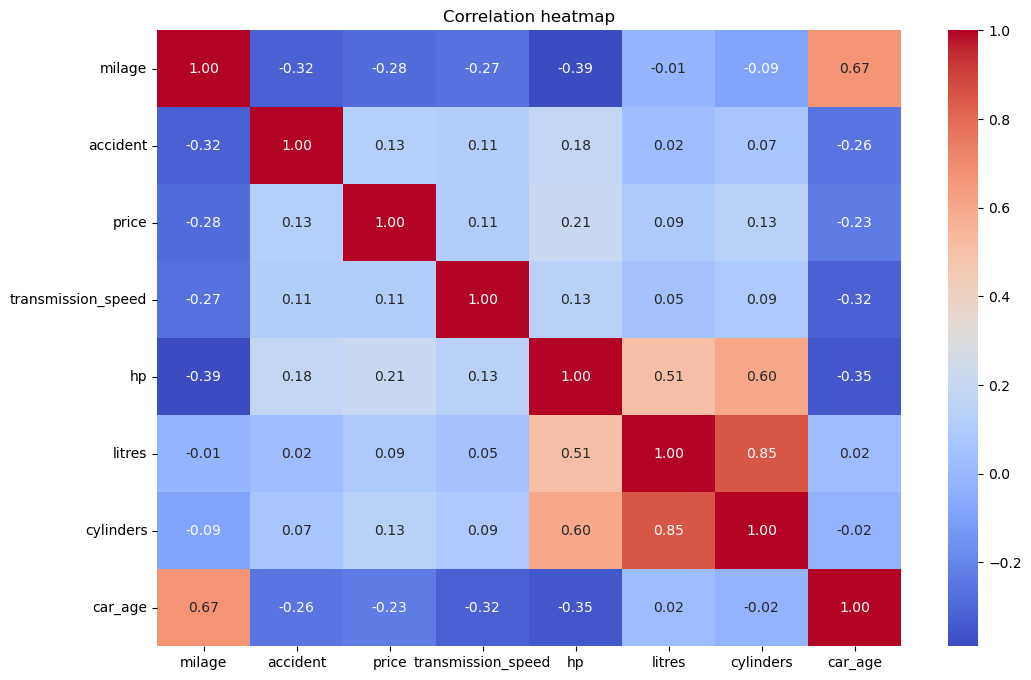

In [166]:
numeric_df =df.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation heatmap")
plt.show()

Data preprocessing

In [167]:
X=df.drop("price", axis=1)
y= np.log1p(df["price"])

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [206]:
encoder = ce.TargetEncoder(cols=["brand", "model","ext_col","int_col"])
X_encoded = encoder.fit_transform(X, y)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded   = encoder.transform(X_test)


In [207]:
X_train_encoded.head()

brand      model  milage fuel_type    ext_col    int_col  \
121111  10.352054  10.740780   40000  Gasoline  10.263677  10.375805   
73926   10.352054  11.178647    6000  Gasoline  10.024142  10.295399   
129773  10.303281  10.432527   59700  Gasoline  10.234305   9.903850   
171600  10.284479   9.813424   64800    Diesel  10.271724   9.821930   
164543  10.276698  10.051033   69700  Gasoline  10.271724  10.375805   

        accident  transmission_speed transmission_mode     hp  litres  \
121111       1.0                   5         autoshift  560.0     4.4   
73926        1.0                   8         automatic  503.0     3.0   
129773       0.0                   6            manual  420.0     4.2   
171600       1.0                   5         automatic  400.0     6.7   
164543       0.0                   5            manual  275.0     2.0   

        cylinders     shape engine_type  car_age  
121111        8.0  Straight    Cylinder        6  
73926         6.0  Straight    Cylinder        2  
129773        8.0  Straight    Cylinder       18  
171600        8.0  Straight    Cylinder       21  
164543        4.0  Straight    Cylinder       15

In [210]:
df_encoded= pd.concat([X_encoded, y], axis=1)

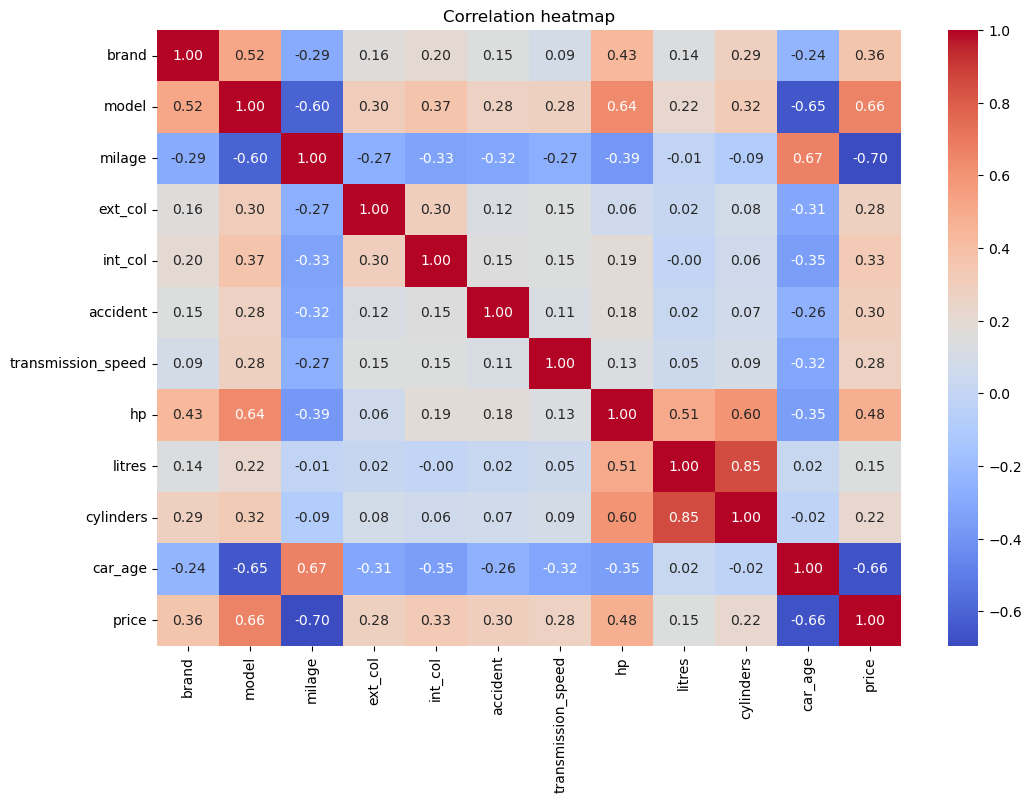

In [211]:
numeric_df =df_encoded.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation heatmap")
plt.show()

In [212]:
def one_hot_encode_fit(train_df, cols):
    train_encoded = pd.get_dummies(train_df, columns=cols).astype(int)

    drop_cols = [c for c in train_encoded.columns if "others" in c.lower()]
    train_encoded = train_encoded.drop(columns=drop_cols, errors="ignore")

    return train_encoded, train_encoded.columns


def one_hot_encode_transform(test_df, cols, train_columns):
    test_encoded = pd.get_dummies(test_df, columns=cols).astype(int)

    drop_cols = [c for c in test_encoded.columns if "others" in c.lower()]
    test_encoded = test_encoded.drop(columns=drop_cols, errors="ignore")

    test_encoded = test_encoded.reindex(columns=train_columns, fill_value=0)

    return test_encoded


In [213]:
cols = ["transmission_mode", "fuel_type", "engine_type", "shape"]
X_encoded, df_columns = one_hot_encode_fit(X_encoded, cols)

X_train_encoded, train_columns = one_hot_encode_fit(X_train_encoded, cols)
X_test_encoded = one_hot_encode_transform(X_test_encoded, cols, train_columns)


In [227]:
# Evaluation function
def evaluate(model, x, y):
    y_pred = model.predict(x)
    y_pred_gbo = np.expm1(y_pred)  
    y_test_ori = np.expm1(y)
    mse=mean_squared_error(y_test_ori, y_pred_gbo)
    rmse = np.sqrt(mean_squared_error(y_test_ori, y_pred_gbo))
    r2=r2_score(y_test_ori, y_pred_gbo)
    print(f"rmse:{rmse}, r2:{r2}, mse:{mse}")

In [175]:
parameters = {
    "DecisionTree":{
        "model":DecisionTreeRegressor(random_state=21),
        "params":{
            "max_depth":[8,10,15]
        }
    },
    "RandomForest":{
        "model":RandomForestRegressor(random_state=21, n_jobs=-1),
           "params":{
               "n_estimators":[200,300],
                "max_depth":[5,10]
        }
    },
    "GradientBoosting":{
        "model":GradientBoostingRegressor(random_state=21),
           "params":{
               "n_estimators":[500,600],
                "max_depth":[7,8]
        }
    }
}

In [176]:
best_models={}
for name, model_param in parameters.items():
    print(f"\n Training {name}")
    grid = GridSearchCV(model_param["model"],model_param["params"],cv=3, scoring= "neg_root_mean_squared_error", verbose=1)
    grid.fit(X_train_encoded, y_train)
    best_models["name"]= grid.best_estimator_
    
    y_pred = best_models["name"].predict(X_test_encoded)
    y_pred_ori = np.expm1(y_pred)  
    y_test_ori = np.expm1(y_test)
    mse=mean_squared_error(y_test_ori, y_pred_ori)
    rmse = np.sqrt(mean_squared_error(y_test_ori, y_pred_ori))
    r2=r2_score(y_test_ori, y_pred_ori)
    print(f"{name} best params:{grid.best_params_}")
    print(f"rmse:{rmse}, r2:{r2}, mse:{mse}")


 Training DecisionTree
Fitting 3 folds for each of 3 candidates, totalling 9 fits
DecisionTree best params:{'max_depth': 8}
rmse:67065.48892683229, r2:0.13937581972371194, mse:4497779804.995065

 Training RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest best params:{'max_depth': 10, 'n_estimators': 300}
rmse:66764.47945069423, r2:0.1470839473545451, mse:4457495716.322171

 Training GradientBoosting
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GradientBoosting best params:{'max_depth': 7, 'n_estimators': 500}
rmse:66380.40138221381, r2:0.15686891369419764, mse:4406357687.663813


In [177]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_encoded, y_train)

LinearRegression()

In [229]:
evaluate(model, X_test_encoded, y_test)

rmse:67947.27326325486, r2:0.1165958807522115, mse:4616831943.911428


In [184]:
from sklearn.linear_model import Ridge, Lasso

ridge_params = {'alpha': [0.5, 1,2]}
ridge = GridSearchCV(Ridge(), ridge_params, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
ridge.fit(X_train_encoded, y_train)

lasso_params = {'alpha': [0.0001,0.001, 0.002, 0.005]}
lasso = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
lasso.fit(X_train_encoded, y_train)

models = {
    "Ridge": ridge.best_estimator_,
    "Lasso": lasso.best_estimator_,
}

for name, model in models.items():
    y_pred = model.predict(X_test_encoded)
    y_pred_ori = np.expm1(y_pred)  
    y_test_ori = np.expm1(y_test)
    
    mae=mean_absolute_error(y_test_ori, y_pred_ori)
    rmse = np.sqrt(mean_squared_error(y_test_ori, y_pred_ori))
    r2=r2_score(y_test_ori, y_pred_ori)
    print(f"\n{name}")
    print(f"Best Params: {getattr(model, 'alpha', 'N/A')}")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")



Ridge
Best Params: 1
RMSE: 67947.2097, MAE: 17925.4014, R²: 0.1166

Lasso
Best Params: 0.0001
RMSE: 67958.6351, MAE: 17920.5422, R²: 0.1163


In [195]:
# Gradient boost regressor
gb_model = GradientBoostingRegressor(n_estimators=650,max_depth=7, random_state=42,verbose=1)

In [196]:
gb_model.fit(X_train_encoded, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.6287           18.34m
         2           0.5587           18.40m
         3           0.5018           18.08m
         4           0.4553           17.81m
         5           0.4172           17.98m
         6           0.3860           17.73m
         7           0.3607           17.78m
         8           0.3399           18.58m
         9           0.3229           18.73m
        10           0.3089           18.69m
        20           0.2516           17.90m
        30           0.2397           17.38m
        40           0.2349           16.74m
        50           0.2320           16.29m
        60           0.2300           15.88m
        70           0.2281           15.48m
        80           0.2265           15.06m
        90           0.2247           14.71m
       100           0.2234           14.35m
       200           0.2110           11.51m
       300           0.2007            8.77m
       40

GradientBoostingRegressor(max_depth=7, n_estimators=650, random_state=42,
                          verbose=1)

In [204]:
evaluate(gb_model, X_test_encoded, y_test)

rmse:66388.5196063204, r2:0.156662673734291, mse:4407435535.518788


In [199]:
# Catboostregressor - Parameter tuning already done to select these parameters
from catboost import CatBoostRegressor
cat_model= CatBoostRegressor(iterations=2000, learning_rate = 0.05, depth =10, eval_metric="RMSE", random_seed=21, verbose=100)

In [201]:
cat_model.fit(X_train_encoded, y_train)

0:	learn: 0.8200200	total: 206ms	remaining: 6m 51s
100:	learn: 0.4925624	total: 3.9s	remaining: 1m 13s
200:	learn: 0.4860842	total: 7.77s	remaining: 1m 9s
300:	learn: 0.4810742	total: 11.6s	remaining: 1m 5s
400:	learn: 0.4768888	total: 15.5s	remaining: 1m 1s
500:	learn: 0.4733237	total: 19.4s	remaining: 58.2s
600:	learn: 0.4699470	total: 23.3s	remaining: 54.3s
700:	learn: 0.4668693	total: 27.3s	remaining: 50.5s
800:	learn: 0.4640006	total: 31.6s	remaining: 47.2s
900:	learn: 0.4613474	total: 36s	remaining: 43.9s
1000:	learn: 0.4587294	total: 40.2s	remaining: 40.1s
1100:	learn: 0.4563003	total: 44.5s	remaining: 36.3s
1200:	learn: 0.4539065	total: 48.8s	remaining: 32.5s
1300:	learn: 0.4515452	total: 53.2s	remaining: 28.6s
1400:	learn: 0.4493945	total: 57.5s	remaining: 24.6s
1500:	learn: 0.4471750	total: 1m 1s	remaining: 20.5s
1600:	learn: 0.4451896	total: 1m 6s	remaining: 16.5s
1700:	learn: 0.4432090	total: 1m 10s	remaining: 12.4s
1800:	learn: 0.4411761	total: 1m 14s	remaining: 8.26s
1900

In [205]:
evaluate(cat_model, X_test_encoded, y_test)

rmse:66300.87621328329, r2:0.15888788245326713, mse:4395806186.649115


In [215]:
dcat_model= CatBoostRegressor(iterations=2000, learning_rate = 0.05, depth =10, eval_metric="RMSE", random_seed=21, verbose=100)
dcat_model.fit(X_encoded, y)

0:	learn: 0.8188376	total: 67.4ms	remaining: 2m 14s
100:	learn: 0.4923690	total: 6.4s	remaining: 2m
200:	learn: 0.4867509	total: 12.8s	remaining: 1m 54s
300:	learn: 0.4821117	total: 19.1s	remaining: 1m 47s
400:	learn: 0.4782257	total: 25.3s	remaining: 1m 41s
500:	learn: 0.4750353	total: 31.7s	remaining: 1m 34s
600:	learn: 0.4719823	total: 38s	remaining: 1m 28s
700:	learn: 0.4692618	total: 44.6s	remaining: 1m 22s
800:	learn: 0.4666135	total: 50.9s	remaining: 1m 16s
900:	learn: 0.4641198	total: 57.2s	remaining: 1m 9s
1000:	learn: 0.4618096	total: 1m 3s	remaining: 1m 3s
1100:	learn: 0.4596441	total: 1m 9s	remaining: 57.1s
1200:	learn: 0.4575839	total: 1m 16s	remaining: 50.8s
1300:	learn: 0.4554180	total: 1m 22s	remaining: 44.4s
1400:	learn: 0.4534647	total: 1m 28s	remaining: 38s
1500:	learn: 0.4516179	total: 1m 35s	remaining: 31.7s
1600:	learn: 0.4498402	total: 1m 41s	remaining: 25.4s
1700:	learn: 0.4481264	total: 1m 48s	remaining: 19s
1800:	learn: 0.4464296	total: 1m 54s	remaining: 12.7s

In [216]:
evaluate(dcat_model, X_test_encoded, y_test)

rmse:64018.484556109936, r2:0.21580127392781934, mse:4098366364.860886


In [218]:
# train model on clean data to allow catboost encode 
categorical_data=['brand','model','fuel_type','ext_col','int_col','transmission_mode','shape',"engine_type"]
cat_model.fit(X, y,  cat_features=categorical_data)

0:	learn: 0.8189695	total: 534ms	remaining: 17m 46s
100:	learn: 0.4894655	total: 46.1s	remaining: 14m 25s
200:	learn: 0.4824770	total: 1m 35s	remaining: 14m 17s
300:	learn: 0.4776897	total: 2m 23s	remaining: 13m 29s
400:	learn: 0.4737036	total: 3m 12s	remaining: 12m 48s
500:	learn: 0.4705924	total: 4m 2s	remaining: 12m 5s
600:	learn: 0.4672263	total: 4m 53s	remaining: 11m 23s
700:	learn: 0.4642782	total: 5m 43s	remaining: 10m 37s
800:	learn: 0.4613237	total: 6m 35s	remaining: 9m 51s
900:	learn: 0.4583881	total: 7m 25s	remaining: 9m 3s
1000:	learn: 0.4554147	total: 8m 17s	remaining: 8m 16s
1100:	learn: 0.4525139	total: 9m 7s	remaining: 7m 27s
1200:	learn: 0.4496661	total: 9m 58s	remaining: 6m 38s
1300:	learn: 0.4470404	total: 10m 49s	remaining: 5m 48s
1400:	learn: 0.4444572	total: 11m 40s	remaining: 4m 59s
1500:	learn: 0.4420732	total: 12m 31s	remaining: 4m 9s
1600:	learn: 0.4398139	total: 13m 23s	remaining: 3m 20s
1700:	learn: 0.4374808	total: 14m 15s	remaining: 2m 30s
1800:	learn: 0.4

In [220]:
evaluate(cat_model, X_test, y_test)

rmse:64306.737313222904, r2:0.20872343218814604, mse:4135356463.871855


In [222]:
# Scaling model to see if it performs better
X_train_scaled = X_train_encoded.copy()
numeric_cols = [col for col in X_train_encoded.columns if X_train_encoded[col].nunique() > 2]
scaler = StandardScaler()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])
X_test_scaled = X_test_encoded.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

In [223]:
scat_model= CatBoostRegressor(iterations=2000, learning_rate = 0.05, depth =10, eval_metric="RMSE", random_seed=21, verbose=100)
scat_model.fit(X_train_scaled, y_train)

0:	learn: 0.8200200	total: 39.1ms	remaining: 1m 18s
100:	learn: 0.4925624	total: 3.79s	remaining: 1m 11s
200:	learn: 0.4860842	total: 7.5s	remaining: 1m 7s
300:	learn: 0.4810742	total: 11.3s	remaining: 1m 3s
400:	learn: 0.4768888	total: 15.1s	remaining: 1m
500:	learn: 0.4733237	total: 18.9s	remaining: 56.6s
600:	learn: 0.4699470	total: 22.8s	remaining: 53s
700:	learn: 0.4668693	total: 26.9s	remaining: 49.8s
800:	learn: 0.4640006	total: 31.2s	remaining: 46.7s
900:	learn: 0.4613474	total: 35.5s	remaining: 43.3s
1000:	learn: 0.4587294	total: 39.8s	remaining: 39.7s
1100:	learn: 0.4563003	total: 44.1s	remaining: 36s
1200:	learn: 0.4539065	total: 48.4s	remaining: 32.2s
1300:	learn: 0.4515452	total: 52.7s	remaining: 28.3s
1400:	learn: 0.4493945	total: 57s	remaining: 24.4s
1500:	learn: 0.4471750	total: 1m 1s	remaining: 20.3s
1600:	learn: 0.4451896	total: 1m 5s	remaining: 16.3s
1700:	learn: 0.4432090	total: 1m 9s	remaining: 12.3s
1800:	learn: 0.4411761	total: 1m 14s	remaining: 8.18s
1900:	learn

In [224]:
evaluate(scat_model, X_test_scaled, y_test)

rmse:66300.87621328329, r2:0.15888788245326713, mse:4395806186.649115


Comment:No improvement after scaling on most models

In [4]:
try:
    test = pd.read_csv('./test.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'car_prices.csv' was not found. Please check the file path.")

Data loaded successfully!


In [256]:
test_df=test.copy()

In [257]:
# Transforming the transmission feature
transmission_sort(test_df)
normalizer = modeNormalizer()
test_df["transmission_mode"]= test_df["transmission_mode"].apply(normalizer.normalize)
speedNormalizer(test_df)

In [258]:
# Transforming the engine feature
test_df[["hp", "litres","cylinders", "shape", "engine_type"]] = test_df["engine"].apply(lambda x: pd.Series(parse_engine_info(x)))

In [259]:
encodeAccident(test_df)
convert_year_to_age(test_df)

In [260]:
filling_missing_values_in_numerical_columns(test_df)
filling_missing_values_in_categorical_columns(test_df)

DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  125690 non-null  int64  
 1   brand               125690 non-null  object 
 2   model               125690 non-null  object 
 3   milage              125690 non-null  int64  
 4   fuel_type           122307 non-null  object 
 5   engine              125690 non-null  object 
 6   transmission        125690 non-null  object 
 7   ext_col             125690 non-null  object 
 8   int_col             125690 non-null  object 
 9   accident            124058 non-null  float64
 10  clean_title         111451 non-null  object 
 11  transmission_speed  125690 non-null  int64  
 12  transmission_mode   125690 non-null  object 
 13  hp                  125690 non-null  float64
 14  litres              125690 non-nul

C:\Users\USER\AppData\Local\Temp\ipykernel_11648\3359797166.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_11648\3359797166.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

id          brand                   model  milage fuel_type  \
0       188533           Land          Rover LR2 Base   98000  Gasoline   
1       188534           Land       Rover Defender SE    9142    Hybrid   
2       188535           Ford      Expedition Limited   28121  Gasoline   
3       188536           Audi           A6 2.0T Sport   61258  Gasoline   
4       188537           Audi    A6 2.0T Premium Plus   59000  Gasoline   
...        ...            ...                     ...     ...       ...   
125685  314218  Mercedes-Benz  GL-Class GL 450 4MATIC   83315  Gasoline   
125686  314219           Audi          Q7 55 Prestige   29336  Gasoline   
125687  314220           Audi    A6 3.0T Premium Plus   77634  Gasoline   
125688  314221           Audi         Q7 3.0T Premium  112000  Gasoline   
125689  314222      Chevrolet                Tahoe LT   66840  Gasoline   

                                                   engine        transmission  \
0            240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel         6-speed-a/t   
1       395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...         8-speed-a/t   
2                         3.5L V6 24V PDI DOHC Twin Turbo  10-speed-automatic   
3                                          2.0 Liter TFSI           automatic   
4            252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                 a/t   
...                                                   ...                 ...   
125685      362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel         7-speed-a/t   
125686                                    3.0 Liter Turbo           automatic   
125687      333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel                 a/t   
125688      333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel                 a/t   
125689       355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel                 a/t   

                ext_col int_col  accident clean_title  transmission_speed  \
0                 White   Beige       1.0         Yes                   6   
1                Silver   Black       1.0         Yes                   8   
2                 White   Ebony       1.0         NaN                  10   
3       Silician Yellow   Black       1.0         NaN                   5   
4                  Gray   Black       1.0         Yes                   5   
...                 ...     ...       ...         ...                 ...   
125685            Black   Black       1.0         Yes                   7   
125686            White   Black       1.0         NaN                   5   
125687            Black   Black       1.0         Yes                   5   
125688            Black   Black       1.0         Yes                   5   
125689           Silver   Black       1.0         Yes                   5   

       transmission_mode     hp  litres  cylinders     shape engine_type  \
0              automatic  240.0     2.0        4.0  Straight    Cylinder   
1              automatic  395.0     3.0        6.0  Straight    Electric   
2              automatic  328.0     3.5        6.0         V        DOHC   
3              automatic  328.0     2.0        6.0       NaN         NaN   
4              automatic  252.0     2.0        4.0  Straight    Cylinder   
...                  ...    ...     ...        ...       ...         ...   
125685         automatic  362.0     3.0        6.0         V    Cylinder   
125686         automatic  328.0     3.0        6.0      None       Turbo   
125687         automatic  333.0     3.0        6.0         V    Cylinder   
125688         automatic  333.0     3.0        6.0         V    Cylinder   
125689         automatic  355.0     5.3        8.0  Straight    Cylinder   

        car_age  
0            10  
1             5  
2             3  
3             9  
4             7  
...         ...  
125685       11  
125686        6  
125687       13  
125688       13  
125689        7  

[125690 rows x 19 columns]

In [261]:
test_df = test_df.drop(["id",'transmission','clean_title','engine'], axis=1)

In [262]:
test_df.fillna({"shape": "others"}, inplace=True)
train_df.loc[train_df["fuel_type"].isna()&train_df["engine"].str.contains("Electric"),"fuel_type"]="Electric"
test_df.fillna({"fuel_type": "others"}, inplace=True)
test_df.fillna({"engine_type": "others"}, inplace=True)
test_df["fuel_type"]=test_df["fuel_type"].str.replace('–', "others")

In [263]:
test_encoded   = encoder.transform(test_df)
test_encoded = one_hot_encode_transform(test_encoded, cols, train_columns)

In [264]:
test_encoded.head()

brand  model  milage  ext_col  int_col  accident  transmission_speed   hp  \
0     10      9   98000       10        9         1                   6  240   
1     10     11    9142        9       10         1                   8  395   
2     10     10   28121       10       10         1                  10  328   
3     10     10   61258       10       10         1                   5  328   
4     10     10   59000       10       10         1                   5  252   

   litres  cylinders  ...  fuel_type_Plug-In Hybrid  fuel_type_not supported  \
0       2          4  ...                         0                        0   
1       3          6  ...                         0                        0   
2       3          6  ...                         0                        0   
3       2          6  ...                         0                        0   
4       2          4  ...                         0                        0   

   engine_type_Cylinder  engine_type_DOHC  engine_type_Electric  \
0                     1                 0                     0   
1                     0                 0                     1   
2                     0                 1                     0   
3                     0                 0                     0   
4                     1                 0                     0   

   engine_type_MPFI  engine_type_Rotary  engine_type_Turbo  shape_Straight  \
0                 0                   0                  0               1   
1                 0                   0                  0               1   
2                 0                   0                  0               0   
3                 0                   0                  0               0   
4                 0                   0                  0               1   

   shape_V  
0        0  
1        0  
2        1  
3        0  
4        0  

[5 rows x 34 columns]

In [265]:
#predicting using catboost on unencoded test model
# y_pred = cat_model.predict(test_df)
# y_test_predicted = np.expm1(y_pred)  

# Predicting using the encoded model
y_pred = dcat_model.predict(test_encoded)
y_test_predicted = np.expm1(y_pred)  

In [266]:
print(y_test_predicted)

[15034.55948482 69086.4764335  54131.03038077 ... 17897.54890534
 12672.49448545 35742.35422515]


In [270]:
submission = pd.DataFrame({
    "id": test["id"], 
    "price": y_test_predicted
})
submission.to_csv("submission.csv", index=False)